# Preparação do ambiente

## Bibliotecas

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import unidecode
import warnings 

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

from string import punctuation

from tabulate import tabulate

from wordcloud import WordCloud

In [22]:
# Settings the warnings to be ignored 
warnings.filterwarnings('ignore')

## Constantes e funções auxiliares

In [2]:
NULL_STRING = '#NULLO#'
MAX_CAT_COUNT = 3

In [3]:
def plot_donut(labels,values,title,startangle=30):
    fig, ax = plt.subplots(figsize=(5, 3), subplot_kw=dict(aspect="equal"))
    
    wedges, texts = ax.pie(values, wedgeprops=dict(width=0.5), startangle=startangle)
    
    bbox_props = dict(boxstyle="round,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")
    
    kw = dict(arrowprops=dict(arrowstyle="-"),bbox=bbox_props,
              zorder=0, va="center")
    
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)
    
    ax.set_title(title)
    plt.show()

In [4]:
def tokenizer(doc):
    doc = doc.lower()
    doc = unidecode.unidecode(doc)
    
    # uniformizar termos
    patterns = [('wi\s?.?fi', 'wifi'), 
                ('2,4', '2.4'), 
                ('5,8', '5.8')]
    for pattern, repl in patterns:
        doc = re.sub(pattern, repl, doc)
    
    stop_words = stopwords.words('portuguese')
    stop_words.extend(stopwords.words('english'))
    stop_words.extend(list(punctuation))
    # stopwords específicas do domínio
    stop_words.extend(['cm', 'feature', 'features', 'informações', 'itens', 'leve', 'list', 'nulo', 'package', 'pacote', 'pacotes', 'recurso', 'tamanho', 'ver', 'unidades', 'fio', 'universal'])
    # cores mais comumns
    stop_words.extend(['preto', 'cinza', 'branco', 'rosa', 'vermelho', 'laranja', 'amarelo', 'verde', 'azul', 'roxo', 'marrom'])
    # remover da lista de stopwords a palavra sem para formar o bigrama "sem fio", que pode ser relevante para o domínio
    # stop_words.remove('sem') 
    
    tokens = [token for token in word_tokenize(doc) if token not in stop_words]
    return tokens

def doc_cleaner(doc):
    tokens = tokenizer(doc)
    return ' '.join(tokens) 

In [31]:
def plot_docs_matrix(docs_matrix, true_targets=None, predicted_targets=None, title=None):
    pca = TruncatedSVD(n_components=2)
    pca_matrix = pca.fit_transform(docs_matrix)
    scatter_x = pca_matrix[:, 0] # first principle component
    scatter_y = pca_matrix[:, 1] # second principle component
    
    if predicted_targets is None:
        fig,ax = plt.subplots(figsize=(6,5))
        if true_targets is not None:
            for group in np.unique(true_targets):
                ix = np.where(true_targets == group)
                ax.scatter(scatter_x[ix], scatter_y[ix], label=group, s=5)
                if title is None:
                    ax.set_title('Documentos por categoria\n(Real)')   
                else:
                    ax.set_title(title)
        else:
            ax.scatter(scatter_x, scatter_y, s=5)
            if title is None:
                ax.set_title('Documentos')
            else:
                ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])
        
    else:
        fig,axs = plt.subplots(1,2,figsize=(12,5))
        if true_targets is not None:
            for group in np.unique(true_targets):
                ix = np.where(true_targets == group)
                axs[0].scatter(scatter_x[ix], scatter_y[ix], label=group, s=5)
                if title is None:
                    axs[0].set_title('Documentos por categoria\n(Real)')   
                else:
                    axs[0].set_title(title)
        else:
            axs[0].scatter(scatter_x, scatter_y, s=5)
            if title is none:
                axs[0].set_title('Documentos')
            else:
                axs[0].set_title(title)
        
        for group in np.unique(predicted_targets):
            ix = np.where(predicted_targets == group)
            axs[1].scatter(scatter_x[ix], scatter_y[ix], label=group, s=5)
            axs[1].set_title('Agrupamento por categoria\n(K-Means)')

        for ax in axs.flat:
            ax.set_xticks([])
            ax.set_yticks([])
        
    plt.show()

In [53]:
def plot_wordcloud(wc_docs,max_words=50,ax=None,title='Principais palavras'):

    if hasattr(wc_docs, '__iter__'):
        wc_docs = ' '.join(wc_docs)
   
    wc = WordCloud(max_words=max_words,height=300).generate(wc_docs)

    if ax is None:
        fig,ax = plt.subplots(figsize=(5,5))
        show_plt = True
    else: 
        show_plt = False
    
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(title)

    if show_plt:
        plt.show()

# Carga e prepação dos dados

In [6]:
raw_amazon_dataset = '../datasets/amazon_reindexed.parquet'
df_amazon = pd.read_parquet(raw_amazon_dataset)
df_amazon.head()

,Link,Palavra_Chave,cat_0,cat_1,cat_2,cat_3,cat_4,cat_5,Marca,Modelo,...,Vendedor,Data_Inclusão,Ativo,Descrição_Principal,Link_Vendedor,Preço_Original,Qtd_disponível,Qtd_vendidos,Desconto,Estado
0,https://www.amazon.com.br/Especiais-Cinematic-...,drone,Eletrônicos e Tecnologia,Câmeras e Foto,Acessórios,Filtros,#NULLO#,#NULLO#,Odorkle,#NULLO#,...,Lantacy,2024-03-06 01:49:12,True,Modelo aplicável: este filtro de listras azuis...,https://www.amazon.com.br/gp/help/seller/at-a-...,#NULLO#,#NULLO#,#NULLO#,#NULLO#,#NULLO#
1,https://www.amazon.com.br/Motores-Escova-Conju...,drone,Eletrônicos e Tecnologia,Câmeras e Foto,Acessórios,Acessórios para Drones,#NULLO#,#NULLO#,Airshi,Airshimowq96xigy-11,...,Aiterwu,2024-03-06 01:49:00,True,Fonte de alimentação: este motor sem escova de...,https://www.amazon.com.br/gp/help/seller/at-a-...,#NULLO#,#NULLO#,#NULLO#,#NULLO#,#NULLO#
2,https://www.amazon.com.br/Armazenamento-Protet...,drone,Brinquedos e Jogos,Brinquedos de Controle Remoto,#NULLO#,#NULLO#,#NULLO#,#NULLO#,Zhjvihx,#NULLO#,...,Zhjvihx-US,2024-03-06 01:48:46,True,Válvula de Alívio de Pressão: Equipada com vál...,https://www.amazon.com.br/gp/help/seller/at-a-...,#NULLO#,#NULLO#,#NULLO#,#NULLO#,#NULLO#
3,https://www.amazon.com.br/EQUSS-V-strom-Motoci...,drone,Eletrônicos e Tecnologia,Câmeras e Foto,Acessórios,Acessórios para Drones,#NULLO#,#NULLO#,Equss,EQUSS,...,Dengzhoushilianzhouqichepeijianshanghang,2024-03-06 01:48:26,True,"[Super Grip] - Design criativo, quatro suporte...",https://www.amazon.com.br/gp/help/seller/at-a-...,#NULLO#,#NULLO#,#NULLO#,#NULLO#,#NULLO#
4,https://www.amazon.com.br/remote-control-brush...,drone,Eletrônicos e Tecnologia,Câmeras e Foto,Acessórios,Acessórios para Drones,#NULLO#,#NULLO#,Uxsiya,Uxsiyay49ekqxi1t,...,Mseinope-US,2024-03-06 01:48:14,True,#NULLO#,https://www.amazon.com.br/gp/help/seller/at-a-...,#NULLO#,#NULLO#,#NULLO#,#NULLO#,#NULLO#


# Análise

## Dados brutos da Amazon

### Categorias definidas pelos vendedores

Os dados brutos da Amazon contém 151.782 registros, desdes, 100.406 não possuem categorias definidas pelos vendedores enquanto os demais estão distribuídos em outras 30 categorias primárias. 

Quase a totalidade dos dados estão distribuídos em duas categorias princiais: 97,8% dos produtos pertencem às categorias "Eletrônicos e Tecnologia" ou "Computadores e Informática"

In [7]:
columns_to_keep = ['cat_0', 'Nome']
df_categories = df_amazon[columns_to_keep].groupby('cat_0',as_index=False).count().sort_values(by='Nome',ascending=False)
df_categories = df_categories.reset_index(drop=True)
df_categories.columns = ['cat_0', 'count']

map_cat_0 = {k:(v if v < MAX_CAT_COUNT else MAX_CAT_COUNT) for v,k in df_categories.cat_0.to_dict().items()}
df_categories['cat_0_int'] = df_categories['cat_0'].map(map_cat_0)

df_categories['cum_sum'] = df_categories['count'].cumsum()
df_categories['cum_part'] = df_categories['cum_sum'].apply(lambda x: x/df_categories['count'].sum()*100)

columns_to_keep = ['cat_0_int', 'count']
df_top_categories = df_categories[columns_to_keep].groupby('cat_0_int',as_index=False).sum()
map_cat_0_int = {0: 'Sem categoria', 1: 'Eletrônicos e Tecnologia', 2: 'Computadores e Informática', 3: 'Outras'}
df_top_categories['top_cat'] = df_top_categories['cat_0_int'].map(map_cat_0_int)

columns_to_keep = ['top_cat', 'count']
df_top_categories = df_top_categories.set_index('cat_0_int')
df_top_categories = df_top_categories[columns_to_keep]

columns_to_keep = ['Categoria', 'Quantidade']
df_top_categories.columns = columns_to_keep

print(tabulate(df_top_categories,showindex=False,headers=columns_to_keep,intfmt=',',tablefmt='rounded_grid').replace(',','.'))

╭────────────────────────────┬──────────────╮
│ Categoria                  │   Quantidade │
├────────────────────────────┼──────────────┤
│ Sem categoria              │      100.406 │
├────────────────────────────┼──────────────┤
│ Eletrônicos e Tecnologia   │       39.062 │
├────────────────────────────┼──────────────┤
│ Computadores e Informática │       11.194 │
├────────────────────────────┼──────────────┤
│ Outras                     │        1.120 │
╰────────────────────────────┴──────────────╯


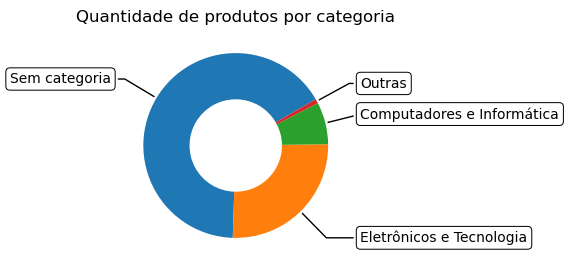

In [8]:
labels = df_top_categories['Categoria'].to_numpy()
values = df_top_categories['Quantidade'].to_numpy()
title = 'Quantidade de produtos por categoria'
startangle = 30

plot_donut(labels, values, title, startangle)

### Documentos no espaço vetorial agrupados por categoria

A visualização dos documentos no espaço vetorial, considerando tanto o título do anúncio quanto a descrição, quando existente, mostrou que as categorias indicadas pelos vendedores podem não ser um bom fator discriminante pois há grande sobreposição de categorias de documentos. 

A aplicação do algortimo de agrupamento K-Means refletiu a sobreposição das categorias e agrupou documentos com categorias sobrepostas em um mesmo grupo.

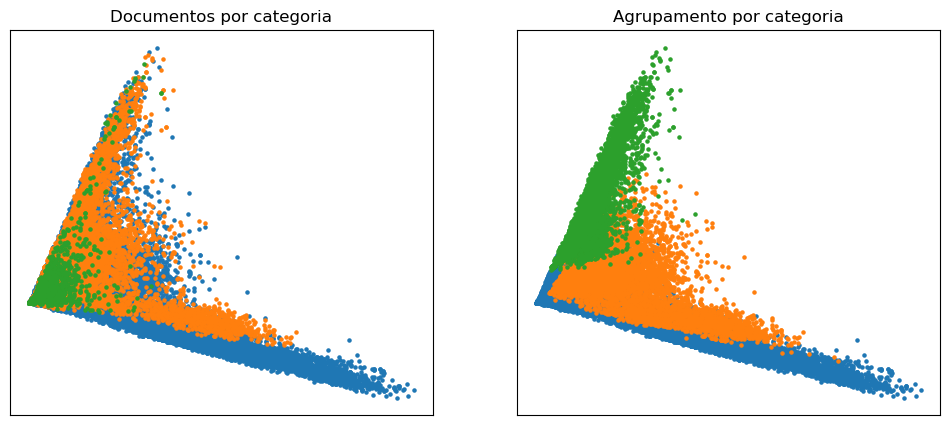

In [26]:
columns_to_keep = ['Nome','cat_0']
df_docs = df_amazon[df_amazon['cat_0']!=NULL_STRING][columns_to_keep]
df_docs['cat_0'] = df_docs['cat_0'].map(map_cat_0)

docs = df_docs['Nome']
targets = df_docs['cat_0']

vectorizer = TfidfVectorizer(tokenizer=tokenizer)
docs_matrix = vectorizer.fit_transform(docs)

kmeans_nome = KMeans(n_clusters=3, max_iter=500, n_init=1).fit(docs_matrix)
predicted_targets = kmeans_nome.labels_

plot_docs_matrix(docs_matrix,true_targets=targets,predicted_targets=predicted_targets)

Observando as principais palavras das categorias e dos grupos (clusters) obtidos através do K-Means, verifica-se mais uma indicação de que as categorias indicadas podem não ser mais adequadas para separação dos produtos. 

Observa-se, por exemplo, que as palavras transmissor e wifi são relevantes para as categorias 2 e 3, fone e ouvido para as categorias 1 e 2. 

Nos grupos (clusters) preditos pelo K-Means fica como primeira precepção que um grupo contém telefones celulares e acessórios, outro contém carregadores e baterias e o terceiro produtos relacionados a aúdio.

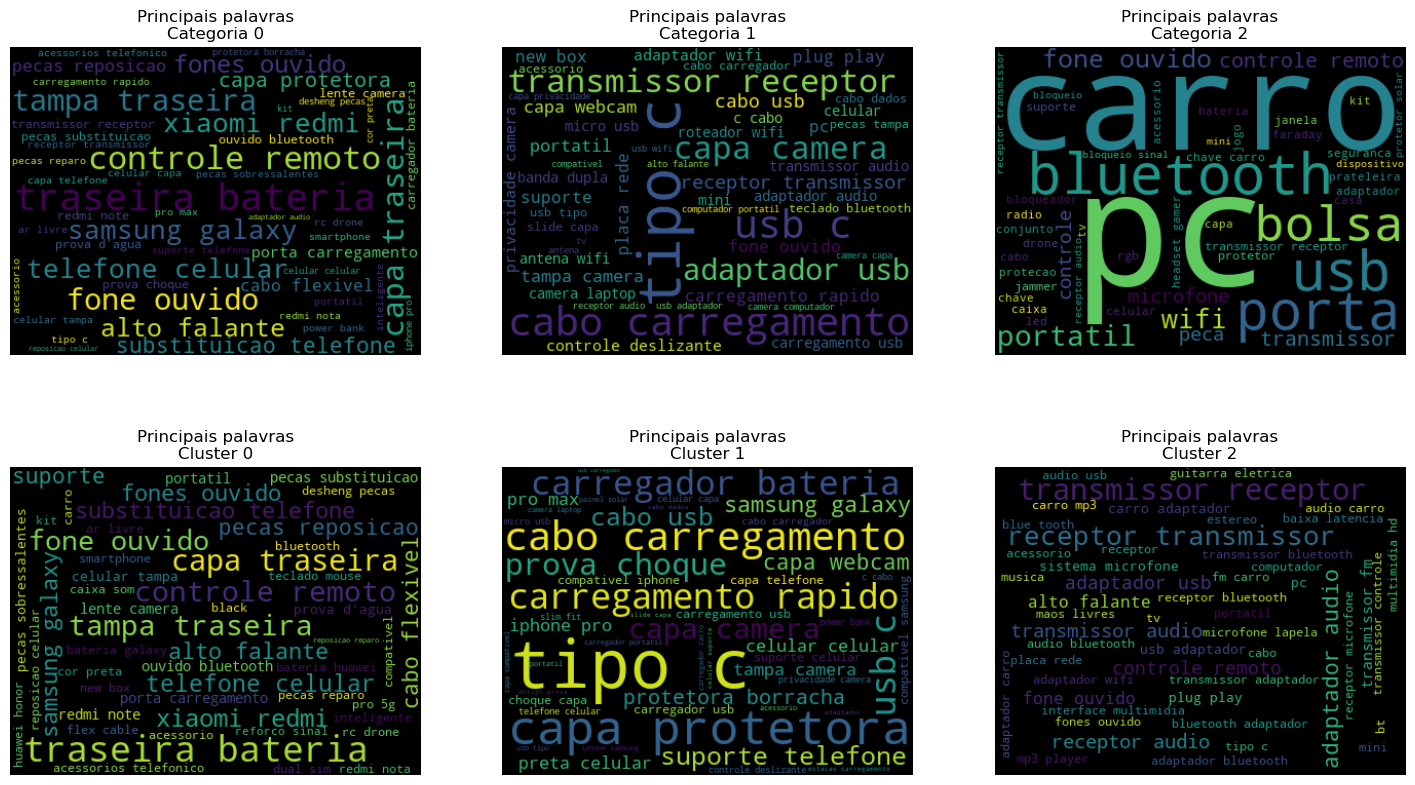

In [78]:
clean_docs = docs.map(doc_cleaner).values

fig,axs=plt.subplots(2,3,figsize=(18,10))

for i,target in enumerate(np.unique(targets)):
    ix = np.where(targets==target)[0]
    plot_wordcloud(clean_docs[ix],ax=axs[0][i],title=f'Principais palavras\nCategoria {i+1}')

for i,target in enumerate(np.unique(predicted_targets)):
    ix = np.where(predicted_targets==target)[0]
    plot_wordcloud(clean_docs[ix],ax=axs[1][i],title=f'Principais palavras\nCluster {i+1}')
    
plt.show()

## Amostra dos dados brutos